## Step 1: Import Libraries

In [17]:
# pip install numpy pandas matplotlib scikit-learn tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

## Step 2: Load and Preprocess the Data

I have downloaded one year of this GBDC (Grayscale Bitcoin Trust) stock here:

https://www.marketwatch.com/investing/fund/gbtc/download-data?startDate=11/2/2022&endDate=11/01/2023

In [4]:
data = pd.read_csv('FUND_US_OOTC_GBTC.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data.set_index('Date', inplace=True)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

## Step 3: Create Sequences

In [10]:
def create_dataset(dataset, time_step=1):
    X_data, y_data = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X_data.append(a)
        y_data.append(dataset[i + time_step, 0])
    return np.array(X_data), np.array(y_data)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

## Step 4: Split the Data into Training and Test Sets

In [13]:
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 5: Reshape the Data

In [14]:
# Reshaping input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

## Step 6: Build and Train the LSTM Model

We’ll use the Long Short-Term Memory (LSTM) network, which is a type of recurrent neural network (RNN) well-suited for sequence prediction problems.

In [15]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, Y_train, validation_data=(x_test, y_test), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
5/5 [==============================] - 3s 170ms/step - loss: 0.0625 - val_loss: 0.0136
Epoch 2/100
5/5 [==============================] - 0s 39ms/step - loss: 0.0195 - val_loss: 0.0129
Epoch 3/100
5/5 [==============================] - 0s 49ms/step - loss: 0.0106 - val_loss: 0.0125
Epoch 4/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0132 - val_loss: 0.0152
Epoch 5/100
5/5 [==============================] - 0s 42ms/step - loss: 0.0104 - val_loss: 0.0069
Epoch 6/100
5/5 [==============================] - 0s 50ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 7/100
5/5 [==============================] - 0s 36ms/step - loss: 0.0079 - val_loss: 0.0053
Epoch 8/100
5/5 [==============================] - 0s 49ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 9/100
5/5 [==============================] - 0s 37ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 10/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 11/100
5/5 [

Epoch 84/100
5/5 [==============================] - 0s 58ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 85/100
5/5 [==============================] - 0s 56ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 86/100
5/5 [==============================] - 0s 52ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 87/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 88/100
5/5 [==============================] - 0s 41ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 89/100
5/5 [==============================] - 0s 48ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 90/100
5/5 [==============================] - 0s 52ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 91/100
5/5 [==============================] - 0s 52ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 92/100
5/5 [==============================] - 0s 56ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 93/100
5/5 [==============================] - 0s 54ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 94/1

## Step 7: Make predictions

In [18]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(x_test)

# Inverse transform to get back to the original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate mean squared error for the predictions
train_mse = mean_squared_error(Y_train, train_predict[:,0])
test_mse = mean_squared_error(y_test, test_predict[:,0])
print(f'Train Mean Squared Error: {train_mse}')
print(f'Test Mean Squared Error: {test_mse}')

2/2 [==============================] - 0s 6ms/step
Train Mean Squared Error: 188.9855438227326
Test Mean Squared Error: 198.03231573711167


## Ploting results

In [19]:
# Inverse scaling the actual test prices
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

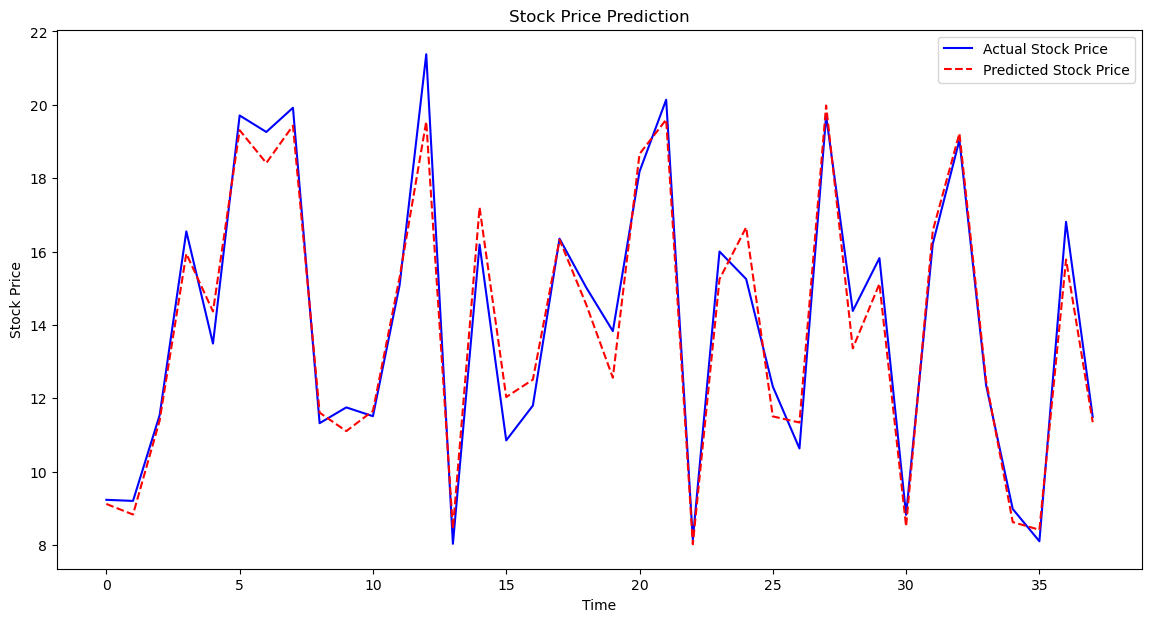

In [20]:
# Plotting the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(test_predict, color='red', linestyle='--', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()